In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from pathlib import Path
from collections import defaultdict
import shutil
from sklearn.utils import resample
import seaborn as sns
from matplotlib.patches import Patch
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, roc_auc_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay


In [2]:
warnings.filterwarnings("ignore")
# Prepare the datasets
# zip_paths = [
#     "/content/sample_data/bending1.zip",
#     "/content/sample_data/bending2.zip",
#     "/content/sample_data/walking.zip",
#     "/content/sample_data/standing.zip",
#     "/content/sample_data/sitting.zip",
#     "/content/sample_data/lying.zip",
#     "/content/sample_data/cycling.zip"
# ]
zip_paths = [
    "bending1.zip",
    "bending2.zip",
    "walking.zip",
    "standing.zip",
    "sitting.zip",
    "lying.zip",
    "cycling.zip"
]
# extract_base_path = Path("/content/sample_data/time_series_data")
extract_base_path = Path("time_series_data")
extract_base_path.mkdir(exist_ok=True)
for zip_file in zip_paths:
    activity = Path(zip_file).stem
    dest_path = extract_base_path / activity
    dest_path.mkdir(exist_ok=True)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(dest_path)
all_files = list(extract_base_path.glob("**/*.csv"))
activity_files = defaultdict(list)
for file in all_files:
    activity = file.parent.name
    activity_files[activity].append(file)
test_files = []
train_files = []
for activity, files in activity_files.items():
    sorted_files = sorted(files, key=lambda f: int(f.stem.replace("dataset", "")))
    if activity in ["bending1", "bending2"]:
        test_files.extend(sorted_files[:2])
        train_files.extend(sorted_files[2:])
    else:
        test_files.extend(sorted_files[:3])
        train_files.extend(sorted_files[3:])
def build_dataset_index(file_list, set_type):
    data = []
    for file_path in file_list:
        activity = file_path.parent.name
        data.append({
            "filepath": str(file_path),
            "activity": activity,
            "set": set_type
        })
    return pd.DataFrame(data)
test_df = build_dataset_index(test_files, "test")
train_df = build_dataset_index(train_files, "train")
full_index_df = pd.concat([train_df, test_df])
# full_index_df.to_csv("/content/sample_data/split.csv", index=False)
full_index_df.to_csv("split.csv", index=False)


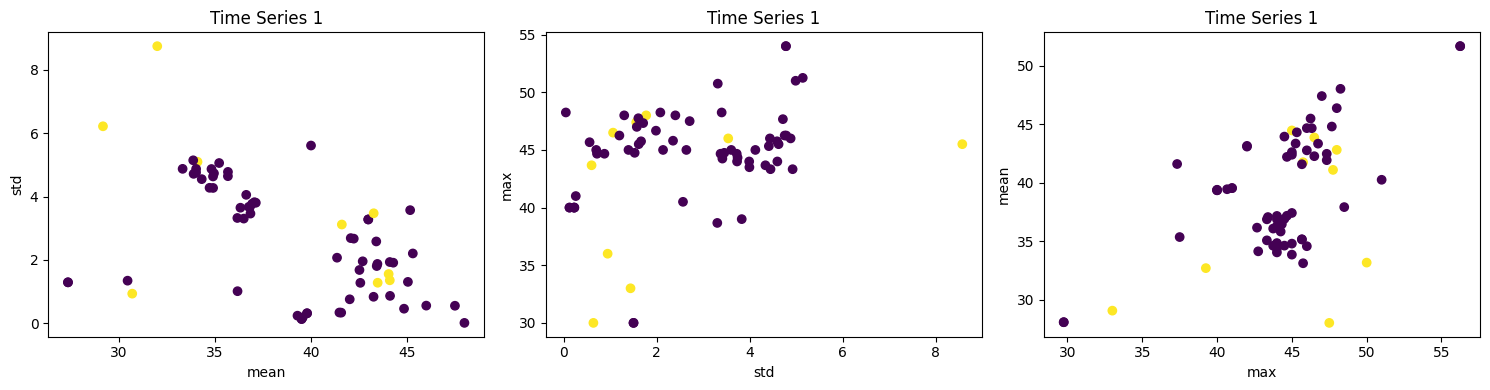

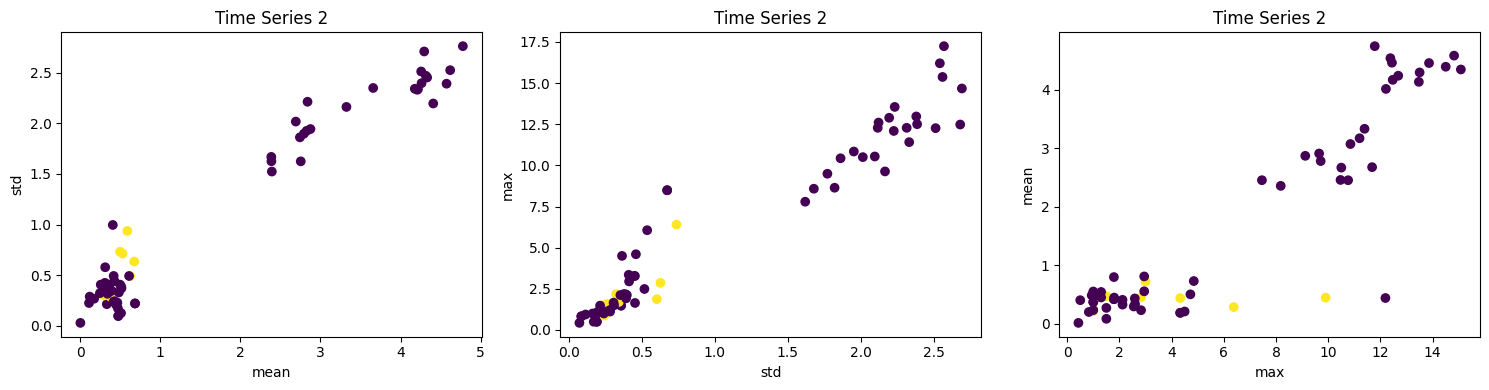

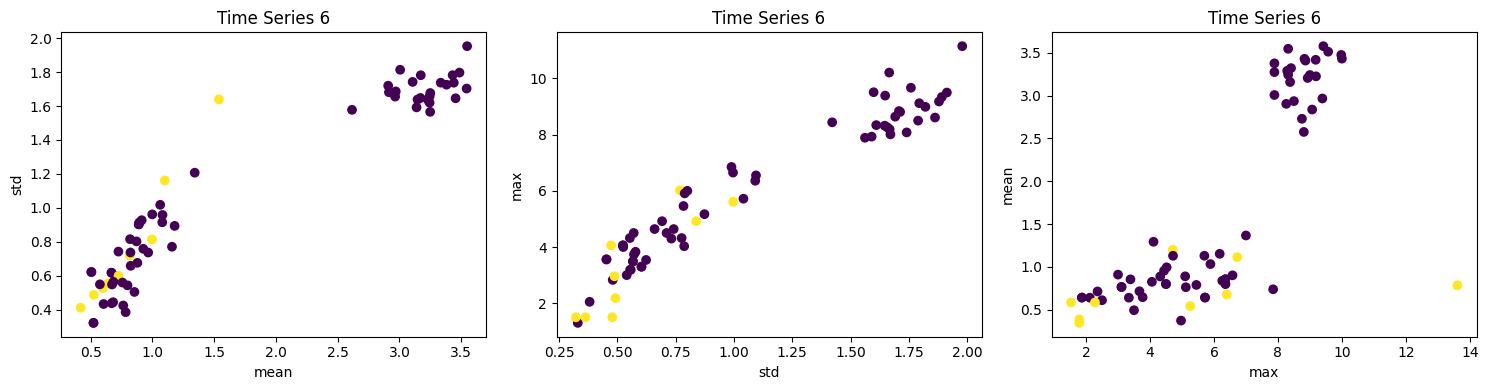

In [10]:
# Break each time series in your training set into two (approximately) equal
# length time series. Now instead of 6 time series for each of the training
# instances, you have 12 time series for each training instance. Repeat the
# experiment in 3(c)v, i.e depict scatter plots of the features extracted from
# both parts of the time series 1,2, and 6.
# split_df = pd.read_csv("/content/sample_data/split.csv")
split_df = pd.read_csv("split.csv")
train_df = split_df[split_df["set"] == "train"]
time_series_column = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
feature_rows = []
labels = []
for _, row in train_df.iterrows():
    df = pd.read_csv(row["filepath"], skiprows=5, header=None)
    df.columns = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

    half = len(df) // 2
    first_half = df.iloc[:half, 1:]
    second_half = df.iloc[half:, 1:]
    features = []
    for half_df in [first_half, second_half]:
        for col in time_series_column:
            features.extend([
                half_df[col].mean(),
                half_df[col].std(),
                half_df[col].max()
            ])
    feature_rows.append(features)
    labels.append(1 if row["activity"] in ["bending1", "bending2"] else 0)
feature_names = []
for half in ["h1", "h2"]:
    for i, col in enumerate(time_series_column, 1):
        feature_names.extend([f"mean_{i}_{half}", f"std_{i}_{half}", f"max_{i}_{half}"])
features_df = pd.DataFrame(feature_rows, columns=feature_names)
features_df["label"] = labels
ts_indices = [1, 2, 6]
for i in ts_indices:
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(features_df[f"mean_{i}_h1"], features_df[f"std_{i}_h1"], c=features_df["label"])
    plt.xlabel("mean")
    plt.ylabel("std")
    plt.title(f"Time Series {i}")
    plt.subplot(1, 3, 2)
    plt.scatter(features_df[f"std_{i}_h2"], features_df[f"max_{i}_h2"], c=features_df["label"])
    plt.xlabel("std")
    plt.ylabel("max")
    plt.title(f"Time Series {i}")
    plt.subplot(1, 3, 3)
    plt.scatter(features_df[f"max_{i}_h1"], features_df[f"mean_{i}_h2"], c=features_df["label"])
    plt.xlabel("max")
    plt.ylabel("mean")
    plt.title(f"Time Series {i}")
    plt.tight_layout()
    plt.show()


In [27]:
# Break each time series in your training set intol∈ {1,2, . . . ,20}time series
# of approximately equal length and use logistic regressionto solve the binary
# classification problem, using time-domain features. Remember that breaking
# each of the time series does not change the number of instances. It only
# changes the number of features for each instance. Calculate the p-values for
# your logistic regression parameters in each model corresponding to each value
# of l and refit a logistic regression model using your pruned set of features.
# Alternatively, you can use backward selection using sklearn.feature selection
# or glm in R. Use 5-fold cross-validation to determine the best value of the pair
# (l, p), where p is the number of features used in recursive feature elimination.
# activity_dirs = {
#     "bending1": "/content/sample_data/time_series_data/bending1",
#     "bending2": "/content/sample_data/time_series_data/bending2",
#     "walking": "/content/sample_data/time_series_data/walking",
#     "standing": "/content/sample_data/time_series_data/standing",
#     "sitting": "/content/sample_data/time_series_data/sitting",
#     "lying": "/content/sample_data/time_series_data/lying",
#     "cycling": "/content/sample_data/time_series_data/cycling"
# }

activity_dirs = {
    "bending1": "bending1",
    "bending2": "bending2",
    "walking": "walking",
    "standing": "standing",
    "sitting": "sitting",
    "lying": "lying",
    "cycling": "cycling"
}

time_series_column = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
# Function to extract features
def extract_segment_features(ts,l):
    segment_len = len(ts) // l
    features = []
    for i in range(l):
        segment = ts[i*segment_len:(i+1)*segment_len]
        features.extend([np.mean(segment), np.std(segment), np.max(segment)])
    return features

results = []
for l in range(1, 21):
    all_features = []
    all_labels = []
    for activity, directory in activity_dirs.items():
        label = 1 if activity in ['bending1', 'bending2'] else 0
        for file in sorted(os.listdir(directory)):
            if file.endswith(".csv"):
                file_path = os.path.join(directory, file)
                df = pd.read_csv(file_path, skiprows=5)
                df.columns = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
                features = []
                for col in df.columns[1:]:
                    ts = df[col].to_numpy()
                    if len(ts) < l:
                        break
                    features.extend(extract_segment_features(ts, l))

                if len(features) == 18 * l:
                    all_features.append(features)
                    all_labels.append(label)
    X = np.array(all_features)
    y = np.array(all_labels)
    if X.shape[0] == 0:
        continue
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_auc = 0
    best_p = 0
    for p in range(5, min(18*l, X.shape[1]) + 1, 5):
        aucs = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            model = LogisticRegression(solver='liblinear', max_iter=1000)
            selector = RFE(model, n_features_to_select=p, step=1)
            X_train_sel = selector.fit_transform(X_train, y_train)
            X_test_sel = selector.transform(X_test)
            model.fit(X_train_sel,y_train)
            prob = model.predict_proba(X_test_sel)[:, 1]
            auc = roc_auc_score(y_test, prob)
            aucs.append(auc)
        avg_auc = np.mean(aucs)
        if avg_auc > best_auc :
            best_auc = avg_auc
            best_p = p
    results.append((l, best_p, best_auc))

results_df = pd.DataFrame(results, columns=["l", "p", "AUC"])
print("\nBest (l, p)    AUC:")
print(results_df.sort_values(by="AUC", ascending=False))

KeyboardInterrupt: 

Right way to perform cross-validation is to use cross-validation after feature selection.Wrong way is to do feature selection first and then do cross-validation.

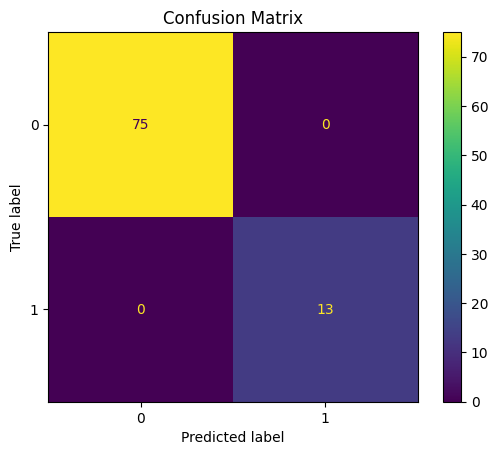

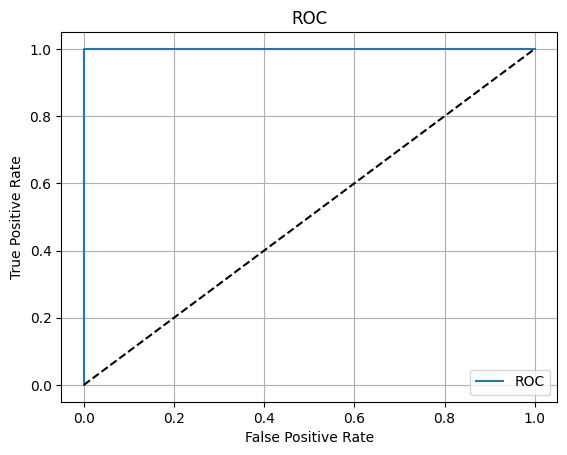

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


    Coefficients (β)
0      -1.854868e-03
1      -1.741264e-01
2      -2.134784e-01
3      -3.994620e-01
4      -1.646470e-01
5      -2.490264e-01
6      -1.741412e-02
7      -1.018491e-01
8      -3.094521e-02
9      -2.792910e-01
10      1.242358e-01
11     -5.495134e-02
12      4.117545e-02
13     -6.264463e-01
14      7.999345e-01
15     -3.425361e-01
16     -2.847591e-17
17     -3.448522e-01
18     -2.432382e-01
19      3.182505e-03
20      5.723374e-01
21      1.069303e+00
22      1.793977e-01
23      9.359653e-02
24      1.620731e-01
25      8.527610e-02
26      6.425220e-03
27      2.829286e-02
28      1.565648e-01
29      2.747650e-01
30      4.683393e-01
31     -3.138242e-01
32     -3.853404e-01
33     -1.745579e-01
34     -3.168327e-01
35     -3.782712e-01


/usr/local/lib/python3.11/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 35 out of 36 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


In [17]:
# Report the confusion matrix and show the ROC and AUC for your classifier
# on train data. Report the parameters of your logistic regression
# βi’s as well as the p-values associated with them

best_l = 11
best_p = 35
X_all = []
y_all = []
for activity, directory in activity_dirs.items():
    label = 1 if activity in ['bending1', 'bending2'] else 0
    for file in sorted(os.listdir(directory)):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, file), skiprows=5)
            df.columns = df.columns = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
            features = []
            for col in df.columns[1:]:
                ts = df[col].to_numpy()
                if len(ts) < best_l:
                    break
                features.extend(extract_segment_features(ts, best_l))
            if len(features) == 18 *best_l:
                X_all.append(features)
                y_all.append(label)
X_all = np.array(X_all)
y_all = np.array(y_all)

# Use RFE
model = LogisticRegression(solver='liblinear', max_iter=1000)
selector = RFE(model, n_features_to_select=int(best_p))
X_selected = selector.fit_transform(X_all, y_all)
selected_feature_indices = selector.get_support(indices=True)
# Train the model
model.fit(X_selected, y_all)
y_pred = model.predict(X_selected)
y_prob = model.predict_proba(X_selected)[:, 1]
# Confusion Matrix
cm = confusion_matrix(y_all, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_all, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend()
plt.grid()
plt.show()
# β
X_stats = sm.add_constant(X_selected, has_constant='add')
model = sm.Logit(y_all, X_stats)
result = model.fit_regularized(alpha=1e-4, L1_wt=0.0, disp=0)
coef_df = pd.DataFrame({"Coefficients (β)": result.params})
print(coef_df)

In [20]:
# Test the classifier on the test set. Remember to break the time series in
# your test set into the same number of time series into which you broke your
# training set. Remember that the classifier has to be tested using the features
# extracted from the test set. Compare the accuracy on the test set with the
# cross-validation accuracy you obtained previously
# split_df = pd.read_csv("/content/sample_data/split.csv")
split_df = pd.read_csv("split.csv")
test_df = split_df[split_df["set"] == "test"]
best_l = 11
best_p = 35
# Extract features
X_test_all = []
y_test_all = []
for _, row in test_df.iterrows():
    label = 1 if row["activity"] in ['bending1', 'bending2'] else 0
    df = pd.read_csv(row["filepath"], skiprows=5)
    df.columns = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    features = []
    for col in df.columns[1:]:
        ts = df[col].to_numpy()
        if len(ts) <best_l:
            break
        features.extend(extract_segment_features(ts, best_l))
    if len(features) == 18 * best_l:
        X_test_all.append(features)
        y_test_all.append(label)

X_test = np.array(X_test_all)
y_test = np.array(y_test_all)

# Use RFE
X_test_selected = selector.transform(X_test)
# Predict on test data
from sklearn.linear_model import LogisticRegression
# Refit
model_sklearn = LogisticRegression(solver='liblinear')
model_sklearn.fit(X_selected, y_all)
y_pred_test = model_sklearn.predict(X_test_selected)
y_prob_test = model_sklearn.predict_proba(X_test_selected)[:, 1]
accuracy = accuracy_score(y_test, y_pred_test)
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Train Accuracy: {best_auc:.4f}")



Test Accuracy: 1.0000
Train Accuracy: 0.9911


It is not well-seperated to cause instability in calculating
logistic regression parameters.

In [ ]:
# From the confusion matrices you obtained, do you see imbalanced classes?
# If yes, build a logistic regression model based on case-control sampling and
# adjust its parameters. Report the confusion matrix, ROC, and AUC of the
# model

In [30]:
# Repeat 4(a)ii using L1-penalized logistic regression,i.e. instead of using p-
# values for variable selection, use L1regularization. Note that in this problem,
# you have to cross-validate for both l, the number of time series into which you
# break each of your instances, and λ, the weight of L1penalty in your logistic
# regression objective function (or C, the budget). Packages usually perform
# cross-validation for λ automatically
best_l = 11
C_values = [10**i for i in range(-4, 3)]
activity_labels = sorted(activity_dirs.keys())
label_map = {act: i for i, act in enumerate(activity_labels)}
def build_dataset(split_df, l):
    X = []
    y = []
    for _, row in split_df.iterrows():
        label = label_map[row["activity"]]
        df = pd.read_csv(row["filepath"], skiprows=5)
        df.columns = ['time'] + selected_columns
        features = []
        for col in df.columns[1:]:
            ts = df[col].to_numpy()
            if len(ts) < l:
                break
            features.extend(extract_segment_features(ts, l))
        if len(features) == 18 * l:
            X.append(features)
            y.append(label)
    return np.array(X), np.array(y)
# split_df = pd.read_csv("/content/sample_data/split.csv")
split_df = pd.read_csv("split.csv")
train_df = split_df[split_df["set"] == "train"]
test_df = split_df[split_df["set"] == "test"]
X_train, y_train = build_dataset(train_df, best_l)
X_test, y_test = build_dataset(test_df, best_l)
# Train L1-penalized multinomial logistic regression
model = LogisticRegressionCV(
    Cs=C_values,
    cv=5,
    penalty='l1',
    solver='saga',
    multi_class='multinomial',
    max_iter=1000,
    scoring='accuracy'
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Error: {1 - test_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'split.csv'

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (7).

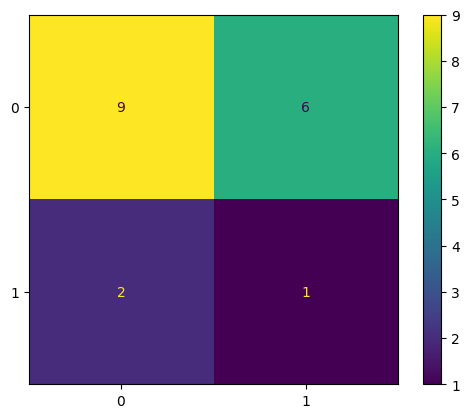

In [29]:
# Repeat 4(c)i using a Naive Bayes’ classifier. Use both Gaussian and
# Multi-nomial pdfs and compare the results
y_test_binarize = label_binarize(y_test, classes=range(len(activity_labels)))

# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
y_prob_gnb = gnb.predict_proba(X_test)
acc_gnb = accuracy_score(y_test, y_pred_gnb)
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gnb, display_labels=activity_labels)
plt.title("Confusion Matrix (Gaussian Naive Bayes)")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()
# ROC Curves
plt.figure(figsize=(8, 6))
for i in range(len(activity_labels)):
    fpr, tpr, _ = roc_curve(y_test_binarize[:, i], y_prob_gnb[:, i])
    auc_g = roc_auc_score(y_test_binarize[:, i], y_prob_gnb[:, i])
    plt.plot(fpr, tpr, label=f"{activity_labels[i]}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Gaussian Naive Bayes")
plt.legend()
plt.grid()
plt.show()

# Train and evaluate Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
y_prob_mnb = mnb.predict_proba(X_test)
acc_mnb = accuracy_score(y_test, y_pred_mnb)
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mnb, display_labels=activity_labels)
plt.title("Confusion Matrix (Multinomial Naive Bayes)")
plt.xticks(rotation=45)
plt.grid()
plt.show()
# ROC Curves
plt.figure(figsize=(8, 6))
for i in range(len(activity_labels)):
    fpr, tpr, _ = roc_curve(y_test_binarize[:, i], y_prob_mnb[:, i])
    auc_m = roc_auc_score(y_test_binarize[:, i], y_prob_mnb[:, i])
    plt.plot(fpr, tpr, label=f"{activity_labels[i]}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multinomial Naive Bayes")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Create p Principal Components from features extracted from features you extracted from
# l time series. Cross validate on the (l, p) pair to build a Na ̈ıve
# Bayes’ classifier based on the PCA features to classify all activities in your
# data set. Report your test error and plot the scatterplot of the classes in your
# training data based on the first and second principal components you found
# from features extracted from ltime series, where l is the value you found
# using cross-validation. Show confusion matrices and ROC curves

L1-penalized multinomial logistic regression is the most effective method for multi-class activity classification in this problem, balancing performance, interpretability, and ease of implementation.